# MELD Dataset - Emotion Recognition Model Evaluation

This notebook evaluates emotion recognition models trained on the **MELD Dataset** (Multimodal EmotionLines Dataset).

## Dataset Information
- **Source**: TV show "Friends" dialogue
- **Emotions**: 7 categories (anger, disgust, fear, joy, neutral, sadness, surprise)


## Models Evaluated
- **Baseline CNN** (audio only)
- **Multimodal CNN** (audio and text)

Results and figures are saved to `results_meld/` and `figures_meld/` folders.

## 1. Setup and Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings

# Configuration
RESULTS_DIR = 'results_meld'
FIGURES_DIR = 'figures_meld'
EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
DATASET_NAME = 'MELD'

# Create figures directory
os.makedirs(FIGURES_DIR, exist_ok=True)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"EVALUATING: {DATASET_NAME} Dataset")
print(f"Results directory: {RESULTS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Number of emotions: {len(EMOTIONS)}")


EVALUATING: MELD Dataset
Results directory: results_meld
Figures directory: figures_meld
Number of emotions: 7


## 2. Load Models and Test Data

In [2]:
# Check if required files exist
required_files = [
    f'{RESULTS_DIR}/baseline_cnn.h5',
    f'{RESULTS_DIR}/multimodal_cnn.h5',
    f'{RESULTS_DIR}/test_data.npz'
]

missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print(f"Missing required files for {DATASET_NAME}:")
    for f in missing_files:
        print(f"  - {f}")
    print("\nPlease run the training script first:")
    print("  python train_meld.py --data-path results_meld --output-path results_meld")
else:
    print(f"All required files found for {DATASET_NAME}")

All required files found for MELD


In [3]:
# Load test data
print(f"\nLoading {DATASET_NAME} test data...")

test_data = np.load(f'{RESULTS_DIR}/test_data.npz')
X_test_audio = test_data['X_audio_test']
X_test_text = test_data['X_text_test']
y_test = test_data['y_test']

# Reshape audio data for CNN input
if len(X_test_audio.shape) == 2:
    X_test_audio = X_test_audio.reshape(X_test_audio.shape[0], X_test_audio.shape[1], 1)

print(f"\n{DATASET_NAME} Test Data:")
print(f"Test samples: {len(y_test)}")
print(f"Audio features shape: {X_test_audio.shape}")
print(f"Text features shape: {X_test_text.shape}")
print(f"Number of emotions: {len(EMOTIONS)}")

print(f"\nEmotion distribution:")
emotion_counts = pd.Series(y_test).value_counts().sort_index()
for idx, count in emotion_counts.items():
    print(f"  {EMOTIONS[idx]:12s}: {count:4d} samples ({count/len(y_test)*100:.1f}%)")


Loading MELD test data...

MELD Test Data:
Test samples: 2610
Audio features shape: (2610, 47, 1)
Text features shape: (2610, 5)
Number of emotions: 7

Emotion distribution:
  anger       :  345 samples (13.2%)
  disgust     :   68 samples (2.6%)
  fear        :   50 samples (1.9%)
  joy         :  402 samples (15.4%)
  neutral     : 1256 samples (48.1%)
  sadness     :  208 samples (8.0%)
  surprise    :  281 samples (10.8%)


In [4]:
# Load models
print(f"\nLoading {DATASET_NAME} models")

baseline_model = tf.keras.models.load_model(f'{RESULTS_DIR}/baseline_cnn.h5')
multimodal_model = tf.keras.models.load_model(f'{RESULTS_DIR}/multimodal_cnn.h5')

print("✓ Models loaded successfully")
print(f"\nModel architectures:")
print(f"Baseline input shape: {baseline_model.input_shape}")
print(f"Multimodal input shapes: {[inp.shape for inp in multimodal_model.inputs]}")


Loading MELD models
✓ Models loaded successfully

Model architectures:
Baseline input shape: (None, 47, 1)
Multimodal input shapes: [TensorShape([None, 47, 1]), TensorShape([None, 5])]


## 3. Generate Predictions

In [5]:
print("Generating predictions...")

# Baseline CNN predictions
y_pred_baseline_proba = baseline_model.predict(X_test_audio, verbose=0)
y_pred_baseline = np.argmax(y_pred_baseline_proba, axis=1)

# Multimodal CNN predictions
y_pred_multimodal_proba = multimodal_model.predict([X_test_audio, X_test_text], verbose=0)
y_pred_multimodal = np.argmax(y_pred_multimodal_proba, axis=1)

print(f"Predictions generated")
print(f"Baseline predictions shape: {y_pred_baseline_proba.shape}")
print(f"Multimodal predictions shape: {y_pred_multimodal_proba.shape}")

Generating predictions...
Predictions generated
Baseline predictions shape: (2610, 7)
Multimodal predictions shape: (2610, 7)


## 4. Calculate Evaluation Metrics

In [6]:
# Calculate metrics for both models
def calculate_metrics(y_true, y_pred, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

# Calculate metrics
baseline_metrics = calculate_metrics(y_test, y_pred_baseline, 'Baseline CNN')
multimodal_metrics = calculate_metrics(y_test, y_pred_multimodal, 'Multimodal CNN')

# Create comparison dataframe
metrics_df = pd.DataFrame([baseline_metrics, multimodal_metrics])
improvement = ((multimodal_metrics['Accuracy'] - baseline_metrics['Accuracy']) / baseline_metrics['Accuracy'] * 100)
metrics_df['Improvement (%)'] = ['—', f"{improvement:+.2f}%"]

## 5. Confusion Matrices

Saved: figures_meld/confusion_matrices_comparison.png


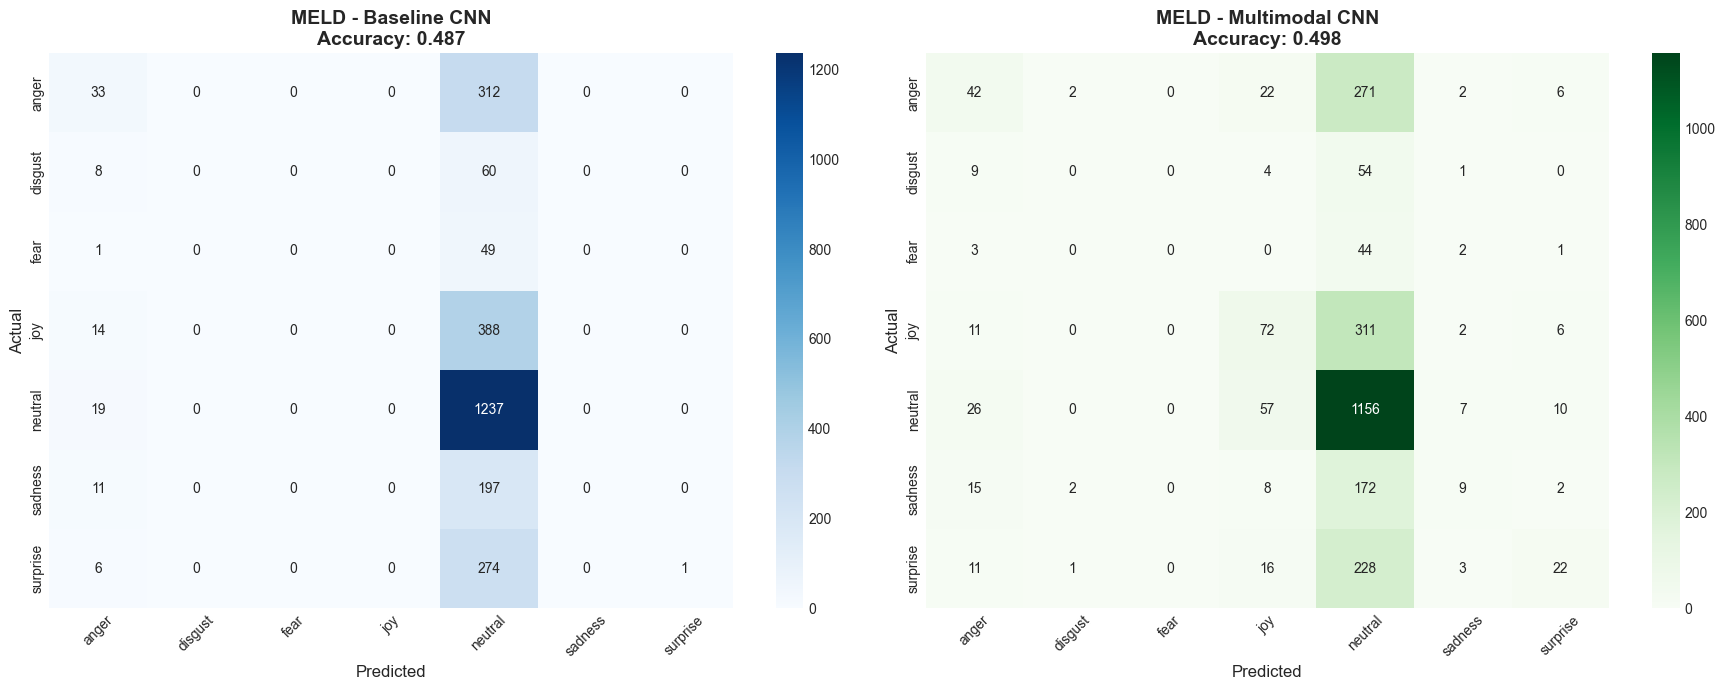

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[0])
axes[0].set_title(f'{DATASET_NAME} - Baseline CNN\nAccuracy: {baseline_metrics["Accuracy"]:.3f}', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Multimodal confusion matrix
cm_multimodal = confusion_matrix(y_test, y_pred_multimodal)
sns.heatmap(cm_multimodal, annot=True, fmt='d', cmap='Greens',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[1])
axes[1].set_title(f'{DATASET_NAME} - Multimodal CNN\nAccuracy: {multimodal_metrics["Accuracy"]:.3f}', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
save_path = f'{FIGURES_DIR}/confusion_matrices_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

## 6. ROC Curves (One-vs-Rest)

Saved: figures_meld/roc_curves_comparison.png


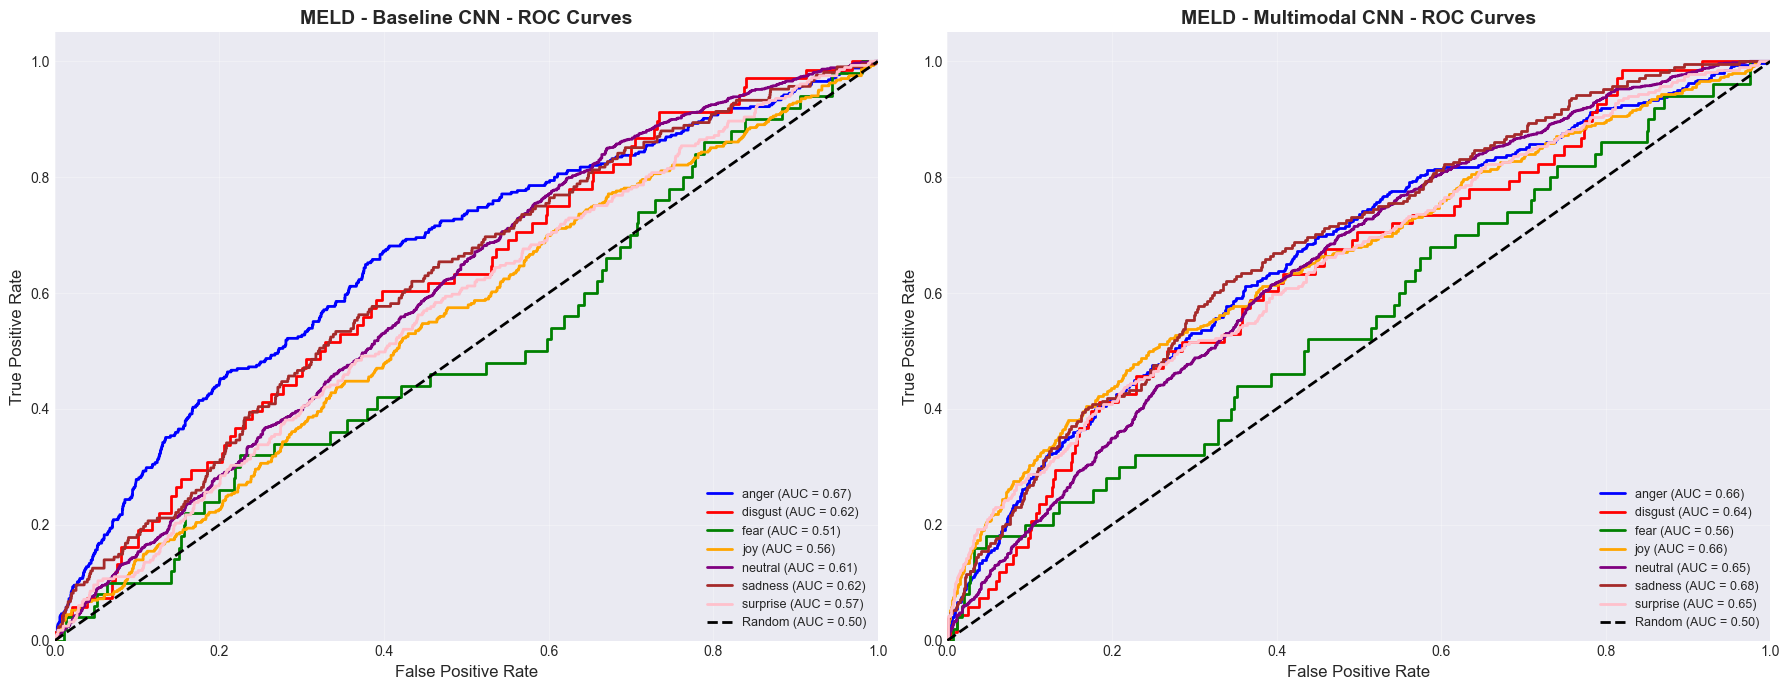


MELD - ROC Analysis:
  Baseline CNN - Mean AUC: 0.593
  Multimodal CNN - Mean AUC: 0.643
  AUC Improvement: +8.44%


In [8]:
# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(EMOTIONS)))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Function to plot ROC curves
def plot_roc_curves(y_true_bin, y_pred_proba, ax, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(EMOTIONS)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])
    for i, color in zip(range(len(EMOTIONS)), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{EMOTIONS[i]} (AUC = {roc_auc[i]:.2f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(alpha=0.3)
    
    return np.mean([roc_auc[i] for i in range(len(EMOTIONS))])

# Plot ROC for both models
mean_auc_baseline = plot_roc_curves(y_test_bin, y_pred_baseline_proba, axes[0], 
                                     f'{DATASET_NAME} - Baseline CNN - ROC Curves')
mean_auc_multimodal = plot_roc_curves(y_test_bin, y_pred_multimodal_proba, axes[1],
                                       f'{DATASET_NAME} - Multimodal CNN - ROC Curves')

plt.tight_layout()
save_path = f'{FIGURES_DIR}/roc_curves_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

print(f"\n{DATASET_NAME} - ROC Analysis:")
print(f"  Baseline CNN - Mean AUC: {mean_auc_baseline:.3f}")
print(f"  Multimodal CNN - Mean AUC: {mean_auc_multimodal:.3f}")
print(f"  AUC Improvement: {((mean_auc_multimodal - mean_auc_baseline) / mean_auc_baseline * 100):+.2f}%")

## 7. Precision-Recall Curves

Saved: figures_meld/precision_recall_curves.png


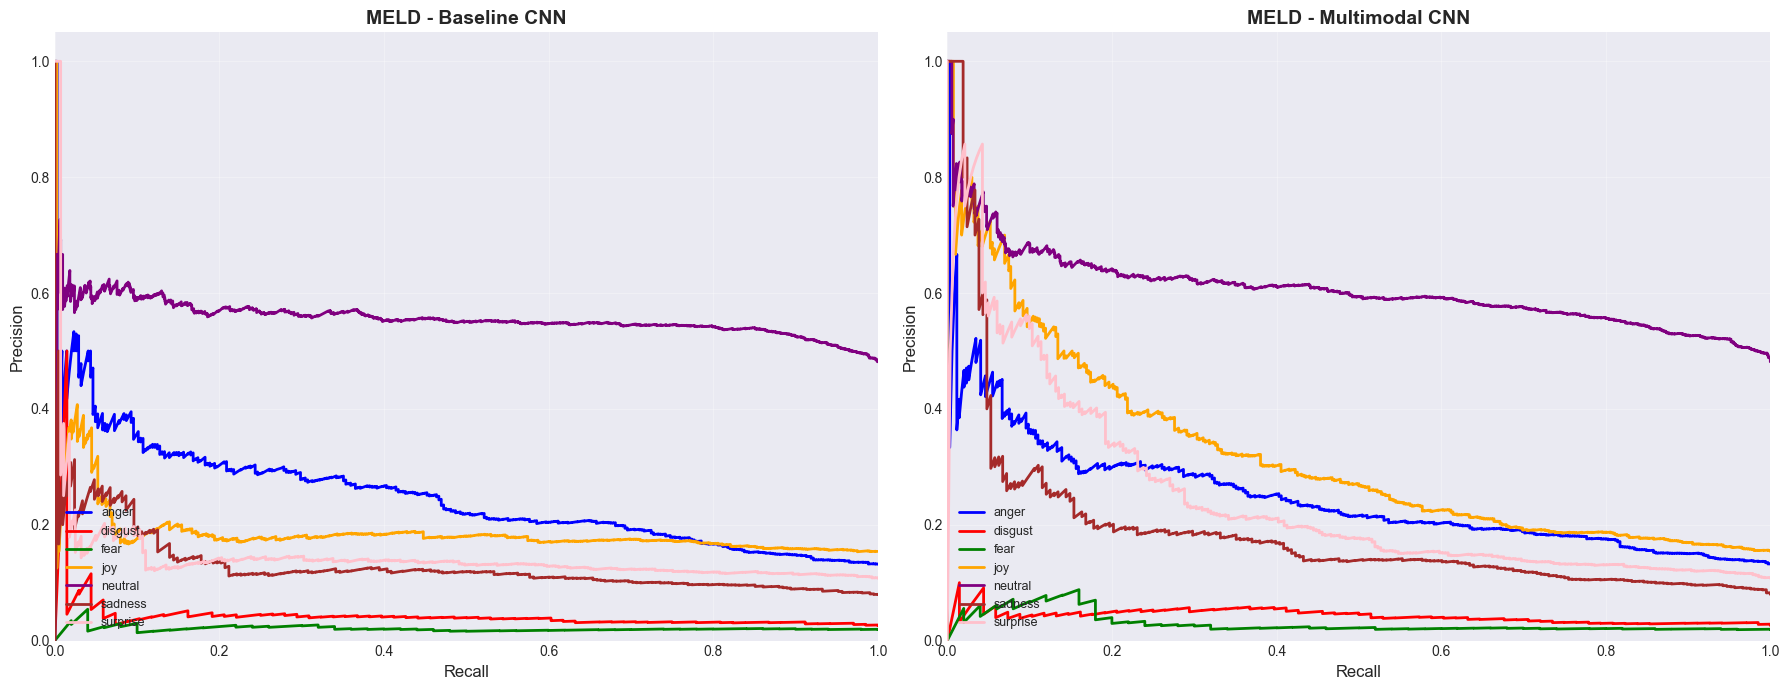

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

def plot_precision_recall(y_true_bin, y_pred_proba, ax, title):
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])
    
    for i, color in zip(range(len(EMOTIONS)), colors):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
        ax.plot(recall, precision, color=color, lw=2, label=EMOTIONS[i])
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc="lower left", fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

plot_precision_recall(y_test_bin, y_pred_baseline_proba, axes[0], 
                      f'{DATASET_NAME} - Baseline CNN')
plot_precision_recall(y_test_bin, y_pred_multimodal_proba, axes[1], 
                      f'{DATASET_NAME} - Multimodal CNN')

plt.tight_layout()
save_path = f'{FIGURES_DIR}/precision_recall_curves.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

## 8. Per-Class F1-Score Comparison

MELD - Per-Class F1-Score Comparison:
 Emotion  Baseline CNN  Multimodal CNN  Improvement
   anger      0.151030        0.181818     0.030788
 disgust      0.000000        0.000000     0.000000
    fear      0.000000        0.000000     0.000000
     joy      0.000000        0.247849     0.247849
 neutral      0.655712        0.662085     0.006373
 sadness      0.000000        0.076923     0.076923
surprise      0.007092        0.134146     0.127054

Saved: figures_meld/f1_score_comparison.png


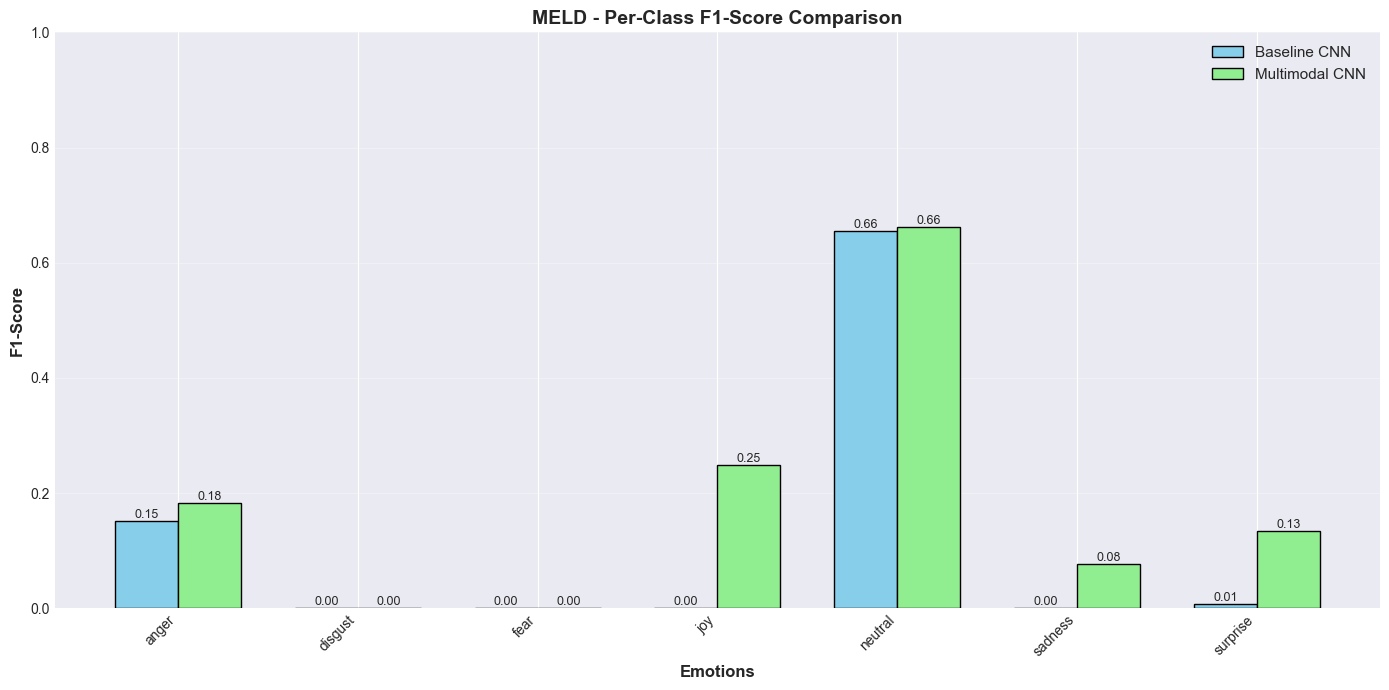

In [10]:
# Calculate per-class F1 scores
f1_baseline = f1_score(y_test, y_pred_baseline, average=None)
f1_multimodal = f1_score(y_test, y_pred_multimodal, average=None)

# Dataframe
f1_comparison = pd.DataFrame({
    'Emotion': EMOTIONS,
    'Baseline CNN': f1_baseline,
    'Multimodal CNN': f1_multimodal,
    'Improvement': f1_multimodal - f1_baseline
})

print(f"{DATASET_NAME} - Per-Class F1-Score Comparison:")
print(f1_comparison.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(EMOTIONS))
width = 0.35

bars1 = ax.bar(x - width/2, f1_baseline, width, label='Baseline CNN', 
               color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, f1_multimodal, width, label='Multimodal CNN', 
               color='lightgreen', edgecolor='black')

ax.set_xlabel('Emotions', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title(f'{DATASET_NAME} - Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(EMOTIONS, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
save_path = f'{FIGURES_DIR}/f1_score_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()